In [10]:
import os
import glob

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [12]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader

In [13]:
# CUDA stuff
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('use cuda: {0}'.format(use_cuda))

use cuda: True


(420, 540)


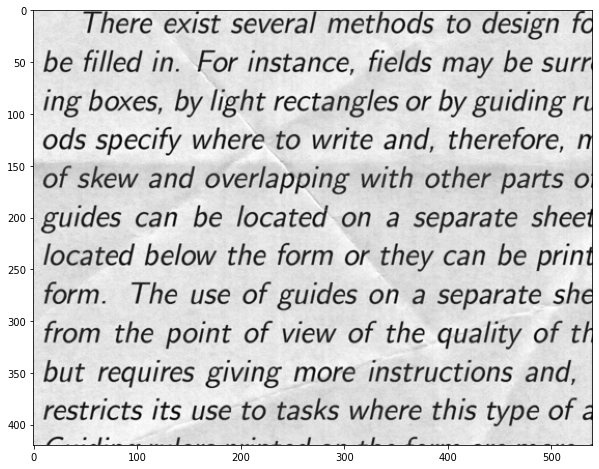

In [14]:
plt.figure(figsize=(20,8))

# flag of 0 means load in greyscale mode
img = cv2.imread('./data/train/101.png', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

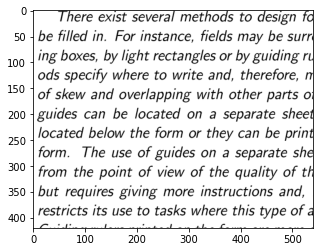

In [15]:
img = cv2.imread('./data/train_cleaned/101.png', 0)
plt.imshow(img, cmap='gray')

In [16]:
img.shape

(420, 540)

TypeError: Image data of dtype object cannot be converted to float

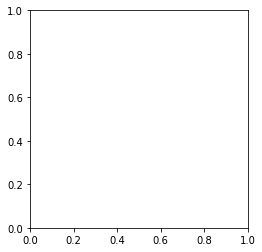

In [17]:
img = cv2.imread('./data/test/101.png', 0)
plt.imshow(img, cmap='gray')

In [18]:
TRAIN_IMAGES = glob.glob('./data/train/*.png')
CLEAN_IMAGES = glob.glob('./data/train_cleaned/*.png')
TEST_IMAGES = glob.glob('./data/test/*.png')

In [10]:
# def load_images(path_arr):
#     image_list = np.zeros((len(path_arr), 258, 540, 1))
#     for i, fig in enumerate(path_arr):
#         img = tv.load_images

In [16]:
# lol = 
# np.zeros((len(TRAIN_IMAGES), 258, 540, 1))

SyntaxError: invalid syntax (<ipython-input-16-3c25904bc65d>, line 1)

In [19]:
class DocumentsDataset(Dataset):
    """documents dataset"""
    
    def __init__(self, dirty_dir, clean_dir, transform=None):
        self.dirty_arr = glob.glob(dirty_dir)
        self.clean_arr = glob.glob(clean_dir)
        self.dirty_dir = dirty_dir
        self.clean_dir = clean_dir
        self.transform = transform
    
    def __len__(self):
        # could be dirty arr or clean arr, shouldn't matter
        return len(self.dirty_arr)
    
    def __getitem__(self, index):
        """Generate one sample of data, based on dirty data"""
        img_name = self.dirty_arr[index]
        dirty_path = os.path.join(self.dirty_dir, img_name)
        clean_path = os.path.join(self.clean_dir, img_name)
        dirty_img = cv2.imread(dirty_path, 0)
        clean_img = cv2.imread(clean_path, 0)
        
        if self.transform:
            dirty_img = self.transform(dirty_img)
            clean_img = self.transform(clean_img)
        
        return dirty_img, clean_img

In [20]:
dirty_dir = './data/train/'

lmao = os.path.join(dirty_dir, '101.png')
lmao

'./data/train/101.png'

In [58]:
# document_dataset = DocumentsDataset(dirty_dir='./data/train/', clean_dir='./data/train_cleaned/')
# document_dataset

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(64, 64, (3, 3))
        self.conv4 = nn.Conv2d(64, 64, (3, 3))
        self.conv5 = nn.Conv2d(64, 64, (3, 3))
        self.conv6 = nn.Conv2d(64, 64, (3, 3))
        
        self.l_relu1 = nn.LeakyReLU()
        self.l_relu2 = nn.LeakyReLU()
        self.l_relu4 = nn.LeakyReLU()
        self.l_relu5 = nn.LeakyReLU()
        
        self.b_norm1 = nn.BatchNorm2d(64)
        self.b_norm4 = nn.BatchNorm2d(64)
        
        self.max_pool3 = nn.MaxPool2d((2, 2))
        
        # can try replacing with nn.ConvTranspose2d if want weights
        self.upsample5 = nn.Upsample(scale_factor=(2, 2), mode='nearest')
        
        self.sigmoid6 = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.l_relu1(x)
        x = self.b_norm1(x)
        
        x = self.conv2(x)
        x = self.l_relu2(x)
        
        x = self.max_pool3(x)
        
        x = self.conv4(x)
        x = self.l_relu4(x)
        x = self.b_norm4(x)
        
        x = self.conv5(x)
        x = self.l_relu5(x)
        x = self.upsample5(x)
        
        x = sigmoid6(x)
        return x

In [23]:
training_set = DocumentsDataset(dirty_dir='./data/train/', clean_dir='./data/train_cleaned/')
training_set


In [25]:
# params = {'batch_size': 64,
#           'shuffle': True,
#           'num_workers': 10}
params = {'batch_size': 4,
          'shuffle': True,
          'num_workers': 1}
max_epochs = 10

training_set = DocumentsDataset(dirty_dir='./data/train/', clean_dir='./data/train_cleaned/')
training_generator = DataLoader(training_set, **params)

# todo: add validation set split and generator

test_set = DocumentsDataset(dirty_dir='./data/test/', clean_dir='./data/train_cleaned/')
test_generator = DataLoader(training_set, **params)




In [27]:
dataiter = iter(training_generator)
dataiter.next()

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/usr/lib/python3/dist-packages/torch/utils/data/_utils/collate.py", line 81, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>


In [57]:
poo = 0
for i, data in enumerate(training_generator):
        # grab inputs
        local_dirty, local_clean = data
        
        if i == 5:
            break
local_dirty

RuntimeError: DataLoader worker (pid(s) 1704, 8740) exited unexpectedly

In [51]:
model = AutoEncoder()

In [54]:

# we gotta square root this later on to make RMSE loss fn
criterion = nn.MSELoss()
# loss = torch.sqrt(criterion)
optimizer = optim.Adam(model.parameters()) # can add lr and momentum params


In [ ]:
running_loss = 

In [56]:
for epoch in range(max_epochs):
    
    running_loss = 0.0
    # training
    for i, data in enumerate(training_generator):
        # grab inputs
        local_dirty, local_clean = data
        
        # transfer to GPU
        local_dirty, local_clean = local_dirty.to(device), local_clean.to(device)
        
        # model computation
        
        # zero param gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(local_dirty)
        
        # loss
        loss = torch.sqrt(criterion(outputs, local_clean))
        loss.backward()
        
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        if True: # i % print_every_n == print_every_n - 1
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1)) # replace denom with print_every_n
            running_loss = 0.0
    
#     # validation
#     with torch.set_grad_enabled(False):
#         for local_dirty, local_clean in validation_generator:
#         # transfer to GPU
#         local_dirty, local_clean = local_dirty.to(device), local_clean.to(device)
        
#         # model computation
#         ... 
        

RuntimeError: DataLoader worker (pid(s) 5808, 6432) exited unexpectedly